# Домашнее задание 2. Детекция, сегментация.

Оценка за часть 1 и часть 2 в этом дз -- по 5 баллов.

In [ ]:
# we will need this library to process the labeling
! pip install xmltodict
# !pip install albumentations==0.4.6
!pip install -U git+https://github.com/albu/albumentations > /dev/null 
!pip install catalyst

In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import xmltodict, json
import albumentations as A
# !pip install --upgrade --force-reinstall --no-deps albumentations
from albumentations.pytorch import ToTensorV2
from albumentations.pytorch import ToTensor
import warnings
warnings.filterwarnings('ignore')

## Часть 1. Object detection.

В этом задании потребуется обучить детектор фруктов на изображении. Датасет можно скачать [отсюда](https://yadi.sk/d/UPwQB7OZrB48qQ).

In [3]:
!wget -O dataset.zip 'https://s296vla.storage.yandex.net/rdisk/0bd17c9009217c16f662608c0341cc7a2219953a212a3f3ca2d8a34f06fb4523/607c6e50/_YfpybMoWZm47imviby-3T3_P-JmBOk_RsfF-4bIvGOZYs-MElyFZHK9g3qV9TPfb6BX2FY5KQyjMDM5DD9_ng==?uid=0&filename=archive.zip&disposition=attachment&hash=lOccmpIYRG/u%2BW1C9jHdqvsadVYmohN46j6tEz%2BQYeOfzEG3Cp1dQ4npcVmx8LuFq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Fzip&owner_uid=365556915&fsize=29737028&hid=d79a0119efd953a38f900e15ed7b0a40&media_type=compressed&tknv=v2&rtoken=TIIxWptYpQX3&force_default=no&ycrid=na-91cfa6cc05163a2183f97aac40455de2-downloader8f&ts=5c042aa3c3400&s=04dc67e4da14ef5bd79c4f0e5a8059d8682e161d38b581f27558559242cd922e&pb=U2FsdGVkX1-vsJZcMQ9ZI76VwT2lYDXz7LanjTBnwyzY_zCz5Px5Kc8YgAZpZ7XwCq6PWjHif7-vEuavikb5I9PXGHtETA3A8V913r2Ej_M' && unzip dataset.zip

--2021-04-18 17:41:41--  https://s296vla.storage.yandex.net/rdisk/0bd17c9009217c16f662608c0341cc7a2219953a212a3f3ca2d8a34f06fb4523/607c6e50/_YfpybMoWZm47imviby-3T3_P-JmBOk_RsfF-4bIvGOZYs-MElyFZHK9g3qV9TPfb6BX2FY5KQyjMDM5DD9_ng==?uid=0&filename=archive.zip&disposition=attachment&hash=lOccmpIYRG/u%2BW1C9jHdqvsadVYmohN46j6tEz%2BQYeOfzEG3Cp1dQ4npcVmx8LuFq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Fzip&owner_uid=365556915&fsize=29737028&hid=d79a0119efd953a38f900e15ed7b0a40&media_type=compressed&tknv=v2&rtoken=TIIxWptYpQX3&force_default=no&ycrid=na-91cfa6cc05163a2183f97aac40455de2-downloader8f&ts=5c042aa3c3400&s=04dc67e4da14ef5bd79c4f0e5a8059d8682e161d38b581f27558559242cd922e&pb=U2FsdGVkX1-vsJZcMQ9ZI76VwT2lYDXz7LanjTBnwyzY_zCz5Px5Kc8YgAZpZ7XwCq6PWjHif7-vEuavikb5I9PXGHtETA3A8V913r2Ej_M
Resolving s296vla.storage.yandex.net (s296vla.storage.yandex.net)... 93.158.162.244, 2a02:6b8:c0e:a86:0:41af:ed72:e739
Connecting to s296vla.storage.yandex.net (s296vla.storage.yandex.net)|93

Датасет мы за вас написали.

In [4]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import xmltodict
import json
import glob
import cv2
import os
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn

class2tag = {"apple": 1, "orange": 2, "banana": 3}
num_classes = 4

class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"].detach().clone(),
                labels=self.annotations[i]["labels"].detach().clone(),
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], {
                "boxes": self.annotations[i]["boxes"].detach().clone(),
                "labels": self.annotations[i]["labels"].detach().clone(),
            }

    def __len__(self):
        return len(self.images)

Выпишем кое-какую техническую работу, которая уже была на семинаре.

In [5]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

Вам мы оставляем творческую часть =)

__Задание__. Обучите модель для object detection на __обучающем__ датасете и добейтесь PR-AUC не менее __0.91__ на  __тестовом__.

 - Создайте модель и оптимайзер
 - Напишите функцию обучения модели
 - Используйте аугментации
 
Использовать аугментации для обучения __обязательно__. Они дадут 1 балл из 5. Пользуйтесь модулем torchvision.transforms или библиотекой albumentations (о которой говорилось ранее). Последняя библиотека особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Советуем обратить внимание на следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). Обратите внимание, что код, написанный в датасете выше, верен только если вы используете albumentations. Если вы выбрали путь torchvision.transforms, вам потребуется метод `__getitem__` изменить (что-то типа `return self.transform(self.images[i])`; однако в таком случае вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную =))

Оставшиеся 4 балла вычисляются по простой формуле: __min(4, 4 * Ваш auc / 0.91)__.

In [6]:
def get_detection_model(num_classes=2):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

def collate_fn(batch):
    return tuple(zip(*batch))

In [7]:
def train_one_epoch(model, train_dataloader, optimizer, summary_writer, epoch, device):
    model.train()
    n = 0
    global_loss = 0
    for images, targets in train_dataloader:
        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        dict_loss = model(images, targets)
        losses = sum(loss for loss in dict_loss.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        n += 1
        global_loss += float(losses.cpu().detach().numpy())

        if n % 20 == 0:
            print("Loss value after {} batches is {}".format(n, round(global_loss / n, 4)))
            summary_writer.add_scalar("train/loss", global_loss / n, n+ 240*epoch)

    return global_loss



def train(model, train_dataloader, val_dataloader, optimizer, device, summary_writer, scheduler, n_epochs=10):
    for epoch in range(n_epochs):
        print('Start of {} epoch'.format(epoch))
        model.train()
        loss = train_one_epoch(model, train_dataloader, optimizer, summary_writer, epoch, device=device)
        model.eval()
        a = evaluate(model, val_dataloader, device=device)
        summary_writer.add_scalar("train/AUC", a, epoch)
        scheduler.step(np.mean(loss))
        print("AUC ON TEST: {:.4f}".format(a))
        print("Оценка за это задание составит {} баллов".format(min(4, 4 * a / 0.91)))
        print()

In [12]:
train_transform = A.Compose([
        A.Flip(),
        A.RandomRotate90(),
        A.Blur(), 
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.6),
        A.RandomBrightnessContrast(),
        A.CLAHE(),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
val_transform = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

train_dataset = FruitDataset("./train_zip/train", transform=train_transform)
val_dataset = FruitDataset("./test_zip/test", transform=val_transform)

model = get_detection_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=1)

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn)

batch_size=1 отработал за 1.12 вместо 1.18 для batch_size=2 (на одной эпохе)

2.38 первая случайная аугментация для теста 

In [9]:
%load_ext tensorboard
import datetime
from torch.utils.tensorboard import SummaryWriter

date = datetime.datetime.now().strftime("%Y.%m.%d-%H:%M:%S")
logdir = "logs_{}".format(date)
writer = SummaryWriter(logdir)

In [13]:
n_epochs = 15
writer = SummaryWriter("{}_{}".format(datetime.datetime.now().strftime("%Y.%m.%d-%H:%M:%S"), 'final'))
train(model, train_dataloader, val_dataloader, optimizer, device, writer, scheduler, n_epochs)

Start of 0 epoch
Loss value after 20 batches is 0.9448
Loss value after 40 batches is 0.6684
Loss value after 60 batches is 0.554
Loss value after 80 batches is 0.5192
Loss value after 100 batches is 0.5156
Loss value after 120 batches is 0.4996
AUC ON TEST: 0.2779
Оценка за это задание составит 1.2215756619506668 баллов

Start of 1 epoch
Loss value after 20 batches is 0.3834
Loss value after 40 batches is 0.3489
Loss value after 60 batches is 0.3663
Loss value after 80 batches is 0.3801
Loss value after 100 batches is 0.372
Loss value after 120 batches is 0.3764
AUC ON TEST: 0.5568
Оценка за это задание составит 2.4474468739709603 баллов

Start of 2 epoch
Loss value after 20 batches is 0.3281
Loss value after 40 batches is 0.3608
Loss value after 60 batches is 0.3283
Loss value after 80 batches is 0.3155
Loss value after 100 batches is 0.3153
Loss value after 120 batches is 0.3151
AUC ON TEST: 0.6824
Оценка за это задание составит 2.9997070211484114 баллов

Start of 3 epoch
Loss value

Некоторые комбинации давали строго больше 0.91, но дабы не переобучаться оставим эту стабильную конфигурацию модели. 

__Выведите итоговое качество модели__.

In [14]:
auc_validation = evaluate(model, val_dataloader, device)
print("Оценка за это задание составит {} баллов".format(min(4, 4 * auc_validation / 0.91)))

Оценка за это задание составит 3.9622763034984607 баллов


Нарисуйте предсказанные bounding box'ы для любых двух картинок из __тестового__ датасета.

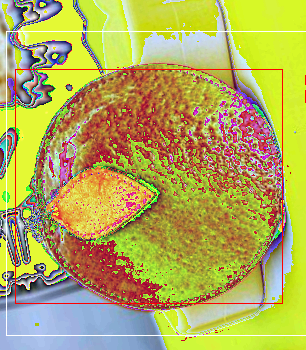

In [21]:
from PIL import ImageDraw
from torchvision import transforms

image, labels = next(iter(train_dataset))
model.eval()
pred = model(image.unsqueeze(0).to(device))[0]
image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

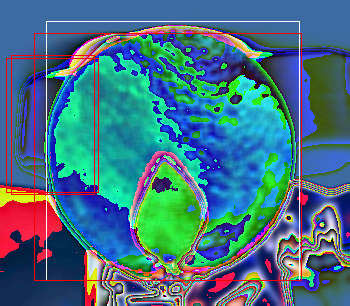

In [20]:
from PIL import ImageDraw
from torchvision import transforms

image, labels = next(iter(train_dataset))
model.eval()
pred = model(image.unsqueeze(0).to(device))[0]
image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

## Часть 2. Сегментация.

В этом задании потребуется обучить модель для семантической сегментации бактерий на изображениях с микроскопа. Скачать данные можно [отсюда](https://disk.yandex.ru/d/nDWwN16rOHKcUg).

Давайте посмотрим на объекты, с которыми вам предстоит работать.

In [25]:
!wget -O dataset.zip 'https://s191vla.storage.yandex.net/rdisk/99a2de90e7454a3b62e93013ee3d8547e8277c3d387b533bef2789839cbf83ee/607cb11b/_YfpybMoWZm47imviby-3YmvUWR2CcazFnofTQcQdqtqle1RwZmmZZhmwl4PdiuUt5rnSSMtZEH7tqr520g9MA==?uid=0&filename=bacteria_data.zip&disposition=attachment&hash=BhMHe4dMrxXPaNxUk7dawA1HsmtnI%2BsW4AvOnnXTo1zmPGWBVmeaelmxdhiHwcHdq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Fzip&owner_uid=365556915&fsize=170141455&hid=5c9396fc07ca0a6e308408a993046014&media_type=compressed&tknv=v2&rtoken=ZlKbTHUcE2IE&force_default=no&ycrid=na-154311b57df592612c3e0d3b588eb213-downloader2h&ts=5c046a56a3cc0&s=7318ee5694af90e7ebdde40dcefd3a15dba5ad921b5738d471dc4e292493242d&pb=U2FsdGVkX18xUzkHB3w4CqmdBWBO7jAPEoBYc-6Fx-wlg_Gv-d2b5rZRDzDr_aab1MIdijB6HyyQC7-rnG73fNGiPqSHt7TpJF4cHsCMk-k' && unzip dataset.zip

--2021-04-18 18:22:41--  https://s191vla.storage.yandex.net/rdisk/99a2de90e7454a3b62e93013ee3d8547e8277c3d387b533bef2789839cbf83ee/607cb11b/_YfpybMoWZm47imviby-3YmvUWR2CcazFnofTQcQdqtqle1RwZmmZZhmwl4PdiuUt5rnSSMtZEH7tqr520g9MA==?uid=0&filename=bacteria_data.zip&disposition=attachment&hash=BhMHe4dMrxXPaNxUk7dawA1HsmtnI%2BsW4AvOnnXTo1zmPGWBVmeaelmxdhiHwcHdq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Fzip&owner_uid=365556915&fsize=170141455&hid=5c9396fc07ca0a6e308408a993046014&media_type=compressed&tknv=v2&rtoken=ZlKbTHUcE2IE&force_default=no&ycrid=na-154311b57df592612c3e0d3b588eb213-downloader2h&ts=5c046a56a3cc0&s=7318ee5694af90e7ebdde40dcefd3a15dba5ad921b5738d471dc4e292493242d&pb=U2FsdGVkX18xUzkHB3w4CqmdBWBO7jAPEoBYc-6Fx-wlg_Gv-d2b5rZRDzDr_aab1MIdijB6HyyQC7-rnG73fNGiPqSHt7TpJF4cHsCMk-k
Resolving s191vla.storage.yandex.net (s191vla.storage.yandex.net)... 77.88.33.128, 2a02:6b8:c0e:91c:0:41af:1c89:42e5
Connecting to s191vla.storage.yandex.net (s191vla.storage.yandex.net)

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize(image, mask):
    
    mask_applied = image.copy()
    mask_applied[mask == 1] = [255, 0, 0]
    mask_applied[mask == 2] = [255, 255, 0]
    
    out = image.copy()
    mask_applied = cv2.addWeighted(mask_applied, 0.5, out, 0.5, 0, out)
    
    fig = plt.figure(figsize=(20, 20))
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(image)
    ax2 = fig.add_subplot(1,3,2)
    ax2.imshow(mask, cmap="gray")
    ax3 = fig.add_subplot(1,3,3)
    ax3.imshow(mask_applied)

def visualize_file(filename):
    image_path = f"./bacteria_data/train/images/{filename}.png"
    mask_path = f"./bacteria_data/train/masks/{filename}.png"
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    visualize(image, mask)


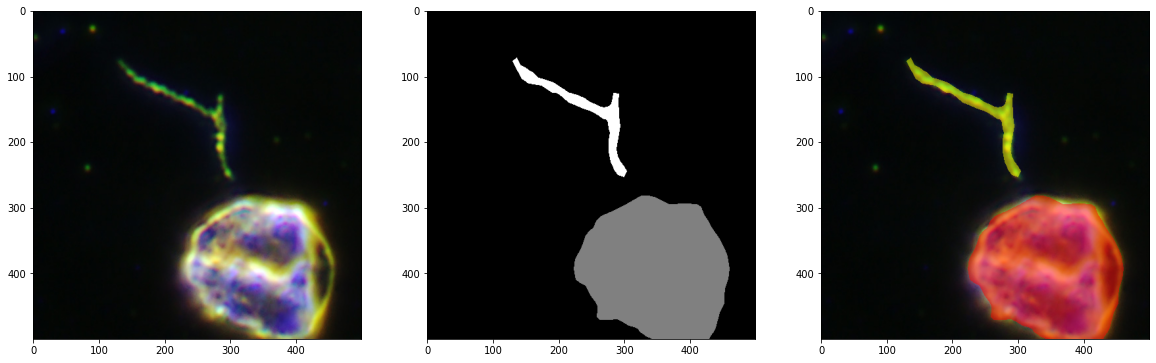

In [27]:
visualize_file("079")

In [28]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F
import os
from PIL import Image


class MaskDataset(Dataset):

    def __init__(
        self,
        root,
        transform=None,
        ):
        """

        :param root: путь к папке с данными
        :param transform: transform the images and labels
        """

        self.root = os.path.expanduser(root)
        self.transform = transform
        (self.data_path, self.labels_path) = ([], [])

        def load_images(path):
            """
            returns all the sorted image paths.

            :param path:
            :return: лист с путями до всех изображений
            """

            images_dir = [os.path.join(path, f) for f in os.listdir(path)
                          if os.path.isfile(os.path.join(path, f))]
            images_dir.sort()

            return images_dir

        self.data_path = load_images(os.path.join(self.root, "images"))
        self.labels_path = load_images(os.path.join(self.root, "masks"))

    def __getitem__(self, index):
        """

        :param index:
        :return: tuple (img, target) with the input data and its label
        """

        img = np.array(Image.open(self.data_path[index]))
        target = np.array(Image.open(self.labels_path[index]))

        if self.transform is not None:
            res = self.transform(image=img, mask=target)
            img = res["image"]
            target = res["mask"]
            target = (target > 0).float()
        
        return (img, target)

    def __len__(self):
        return len(self.data_path)

Попробуем разные аугментации из [albumentations](https://albumentations.ai/docs/examples/example_kaggle_salt/). Всякие Non-rigid transformations не взлетели. Финальный вариант:

In [29]:
from torchvision.transforms import ToTensor, Compose
import albumentations as A
import cv2

train_transform=A.Compose([
        A.Resize(height = 256, width = 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.Blur(),
        A.RandomBrightnessContrast(p=0.2),
        A.ChannelShuffle(),
        ToTensorV2(transpose_mask = True, always_apply = True, p=1.0),
      ])
valid_transform=A.Compose([
        A.Resize(height = 256, width = 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(transpose_mask = True, always_apply = True, p=1.0),
      ])


train_dataset = MaskDataset("./bacteria_data/train", transform=train_transform)
test_dataset = MaskDataset("./bacteria_data/test", transform=valid_transform)

len(train_dataset), len(test_dataset)

(293, 73)

Картинок, как видим, не очень-то много, но для задачи сегментации это считается нормой.

Итак, собственно __задание__. Обучите модель сегментации, способную давать значение метрики intersection over union (то же что и мера Жакара) __не менее 0.7__. Вычисление этой метрики выписано ниже.

 - Создайте модель и оптимайзер
 - Напишите функцию обучения модели
 - Используйте аугментации

Использовать аугментации для обучения __обязательно__. Они дадут 1 балл из 5. Пользуйтесь модулем torchvision.transforms или библиотекой albumentations (о которой говорилось ранее). Последняя библиотека особенно удобна, поскольку умеет сама вычислять новые сегментационные маски после трансформаций картинки. Обратите внимание, что код, написанный в датасете выше, верен только если вы используете albumentations. Если вы выбрали путь `torchvision.transforms`, вам потребуется метод __getitem__ изменить (что-то типа return self.transform(self.images[i]); однако в таком случае вычислять маски после трансформаций вам придётся вручную =))

 Для выполнения этой задачи напишите функцию train_one_epoch, смысл которой вы должно быть помните из предыдущих домашек.


Вот несколько хинтов:
 - Используйте schedule на learning rate
 - Используйте ЖЁСТКИЕ аугментации на трейн и слабые на валидацию
 - Можно использовать имплементированные модели (например модификации UNet) из библиотеки [catalyst](https://catalyst-team.github.io/catalyst/v20.04.2/api/contrib.html#module-catalyst.contrib.models.cv.segmentation.unet) или других библиотек с открытым исходным кодом и обязательно указывайте __ссылку на код__ (если этот код не решает конкретно поставленную задачу в этом дз). Заметьте, что за списывание без указание ссылки предусмотрены жестокие наказания, а в интернете очень много неработающего кода. Будьте внимательны.
 - Попробуйте обучаться с [Dice](https://arxiv.org/pdf/1707.03237.pdf) или [фокальным](https://arxiv.org/pdf/2006.14822.pdf) лоссом. Имплементацию можете найти в catalyst'е.

In [30]:
from tqdm.notebook import tqdm
import numpy as np


def iou_calculate(mask, pred):
    mask = mask.cpu().numpy()
    pred = pred.cpu().numpy()
    intersection = (mask * pred).sum()
    union = (mask + pred).sum() - intersection
    return (intersection / union).item()


def evaluate(model, dataloader, device, threshold=0.5):
    model.eval().to(device)
    progress_bar = tqdm(dataloader)
    pred_masks = []
    true_masks = []
    with torch.no_grad():
        for image, mask in progress_bar:
            image, mask = torch.stack(image).to(device), torch.stack(mask).to(device)
            res = model(image)
            pred_masks.append((res.sigmoid() > threshold).int())
            true_masks.append(mask.int())
    iou_result = iou_calculate(torch.cat(true_masks), torch.cat(pred_masks))
    return iou_result

def train_one_epoch(model, dataloader, optimizer, criterion, device):

    model.train()
    pbar = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, (images, labels) in pbar:
        
        images = torch.stack(images).to(device)
        labels = torch.stack(labels).to(device)

        optimizer.zero_grad()
        outputs = torch.sigmoid(model(images))

        loss = criterion(outputs, labels)
        
        accuracy = ((outputs > 0.5) == labels).float().mean()
            
        pbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
        )

        loss.backward()
        optimizer.step()
    

def train(model, train_dataloader, val_dataloader, optimizer, criterion, device, scheduler = None, threshold=0.5, epochs=10):
    for epoch in range(epochs):
        train_one_epoch(model, train_dataloader, optimizer, criterion, device)
        iou_result = evaluate(model, val_dataloader, device, threshold)
        scheduler.step(iou_result)
        print("IoU on val set = {:.4f}".format(iou_result))


In [37]:
from catalyst.contrib.models.cv.segmentation.unet import ResnetUnet 

def collate_fn(batch):
  return tuple(zip(*batch))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResnetUnet(num_classes = 3, pretrained=True, arch="resnet18")
model.to(device)
criterion = torch.nn.BCELoss().cuda()
optimizer = torch.optim.RMSprop(model.parameters(), weight_decay=1e-4, lr=1e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=2)

train_dl = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=4, shuffle=True, pin_memory=True, num_workers=2, collate_fn=collate_fn)
test_dl = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=2, shuffle=False, pin_memory=True, num_workers=1, collate_fn=collate_fn)

assert all(len(item) == 2 for item in train_dl)
assert all(len(item) == 2 for item in test_dl)
assert sum(len(item[0]) for item in train_dl) == 293
assert sum(len(item[0]) for item in test_dl) == 73
print("all checks passed! ready for training")

all checks passed! ready for training


In [38]:
train(model, train_dl, test_dl, optimizer, criterion, device, scheduler, threshold=0.5, epochs=15)


IoU on val set = 0.6359



IoU on val set = 0.6440



IoU on val set = 0.6943



IoU on val set = 0.4543



IoU on val set = 0.7197



IoU on val set = 0.6468



IoU on val set = 0.6926



IoU on val set = 0.7366



IoU on val set = 0.7415



IoU on val set = 0.7410



IoU on val set = 0.7452



IoU on val set = 0.7420



IoU on val set = 0.7426



IoU on val set = 0.7454



IoU on val set = 0.7362


Визуализируем предсказания нейронки. Для этого нарисуем исходную картинку и предсказанную маску поверх неё. Если вы сделали всё правильно, должно получиться красиво =)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
3
(256, 256, 3)


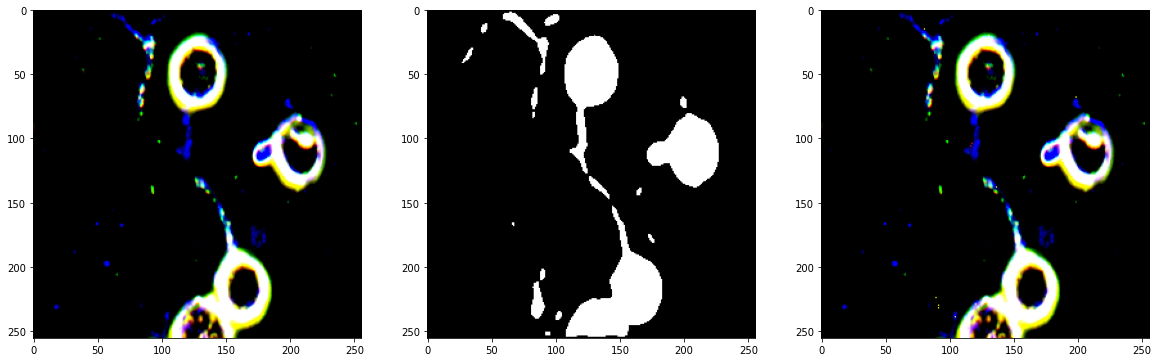

In [33]:
def visualize_random_image(model, dataset):
    model.eval().cpu()
    with torch.no_grad():
        i = np.random.randint(0, len(dataset))
        img, mask = dataset[i]
        predicted_mask = model(img[None].cpu())
        print((predicted_mask > 0.5)[0].shape)
        predicted_mask = (predicted_mask > 0.6)[0]
        predicted_mask = predicted_mask[0] * 0 + predicted_mask[1] * 1 + predicted_mask[2] * 2
        predicted_mask = predicted_mask.int().numpy()
        print(predicted_mask.max())
        img = img.cpu().numpy().transpose((1, 2, 0))
    print(img.shape)

    visualize(img, predicted_mask)

visualize_random_image(model, test_dataset)